In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
import copy
import pickle
import urllib
import logging
from datetime import datetime

import requests
from tqdm import tqdm_notebook
tqdm = tqdm_notebook

from IPython.core.display import display, HTML

import numpy as np
import pandas as pd

import holoviews as hv
import hvplot.pandas

from bokeh.plotting import save, output_notebook
output_notebook()

import graph_tool.all as gt

from dvidutils import LabelMapper
from libdvid import DVIDNodeService

from neuclease.dvid import *
from neuclease.misc.vnc_statuses import fetch_vnc_statuses
from neuclease.clio.api import fetch_json_annotations_all

Loading BokehJS ...

/opt/miniconda/envs/flyem-july/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::__1::vector<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::allocator<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)


In [3]:
from neuclease.clustering.blockmodel import construct_layered_graph

In [4]:
handler = logging.StreamHandler(sys.stdout)
root_logger = logging.getLogger()
root_logger.handlers = []
root_logger.addHandler(handler)
root_logger.setLevel(logging.INFO)
logging.getLogger('kafka').setLevel(logging.WARNING)

In [5]:
pwd

'/Users/bergs/workspace/neuclease/notebooks'

In [6]:
del vnc_master
del vnc_seg

In [7]:
vnc_locked_seg

('emdata5.janelia.org:8400',
 '8c88492af2624362a8fabf87a724a6d8',
 'segmentation')

In [8]:
SYNAPSES_DIR = '/Users/bergs/data/vnc/synapses'

In [9]:
CLIO_ANNOTATIONS_DIR = '/Users/bergs/data/vnc'

In [10]:
VNC_LINK_STATE = '/Users/bergs/workspace/flyem-private-links/vnc/dvid-seg.json'

In [11]:
with open(f'{SYNAPSES_DIR}/full_partner_df.pkl', 'rb') as f:
    partner_df = pickle.load(f)

In [12]:
with open(f'{SYNAPSES_DIR}/point_df-with-bodies-75181d.pkl', 'rb') as f:
    point_df = pickle.load(f)

In [13]:
partner_df = partner_df.merge(point_df['body'], 'left', left_on='pre_id', right_index=True)
partner_df = partner_df.merge(point_df['body'], 'left', left_on='post_id', right_index=True, suffixes=['_pre', '_post'])

In [14]:
with open(f'{SYNAPSES_DIR}/full_partner_df-with-bodies-75181d.pkl', 'wb') as f:
    pickle.dump(partner_df, f)

In [15]:
with open(f'{SYNAPSES_DIR}/full_partner_df-with-bodies-75181d.pkl', 'rb') as f:
    partner_df = pickle.load(f)

In [16]:
partner_df

pre_id  z_pre  y_pre  x_pre kind_pre  conf_pre user_pre  \
0         240406077070379755  54662  27981   2795   PreSyn     0.836     $fpl   
1         240406077070379755  54662  27981   2795   PreSyn     0.836     $fpl   
2         240406077070379755  54662  27981   2795   PreSyn     0.836     $fpl   
3         241531976046086898  54918  27537   2802   PreSyn     0.785     $fpl   
4         241531976046086898  54918  27537   2802   PreSyn     0.785     $fpl   
...                      ...    ...    ...    ...      ...       ...      ...   
86228828  224568732184258417  51061  37804  42865   PreSyn     0.759     $fpl   
86228829  224568732184258417  51061  37804  42865   PreSyn     0.759     $fpl   
86228830  224568732184258417  51061  37804  42865   PreSyn     0.759     $fpl   
86228831  224568732184258417  51061  37804  42865   PreSyn     0.759     $fpl   
86228832  224568732184258417  51061  37804  42865   PreSyn     0.759     $fpl   

                     post_id  z_post  y_post  x_post kind_post  conf_post  \
0         240366494676945628   54653   27993    2780   PostSyn   0.990273   
1         240445659509951205   54671   27991    2789   PostSyn   1.000000   
2         240581998918241028   54702   27975    2820   PostSyn   0.206855   
3         241575956527975151   54928   27545    2799   PostSyn   0.997869   
4         241369248371313377   54881   27559    2785   PostSyn   0.221628   
...                      ...     ...     ...     ...       ...        ...   
86228828  224524751675107214   51051   37783   42894   PostSyn   0.263888   
86228829  224599518530807665   51068   37814   42865   PostSyn   0.999885   
86228830  224524751696078691   51051   37793   42851   PostSyn   0.558182   
86228831  224432392704665444   51030   37786   42852   PostSyn   0.839957   
86228832  224599518505641814   51068   37802   42838   PostSyn   0.278612   

         user_post  body_pre    body_post  
0             $fpl     16698        20381  
1             $fpl     16698        57807  
2             $fpl     16698  43688825802  
3             $fpl     22450        18817  
4             $fpl     22450  44095597090  
...            ...       ...          ...  
86228828      $fpl     75444  40886614105  
86228829      $fpl     75444  40886615625  
86228830      $fpl     75444  40886616571  
86228831      $fpl     75444  40886616854  
86228832      $fpl     75444  40886617367  

[86228833 rows x 16 columns]

In [17]:
ann = fetch_body_annotations(*vnc_locked)

In [18]:
vstats = fetch_vnc_statuses(*vnc_locked)

Pre-sorting 15782 coordinates by block index...
Pre-sorting 15782 coordinates by block index took 0:00:00.010640
Fetching labels from DVID...


  0%|          | 0/4 [00:00<?, ?it/s]

Fetching labels from DVID took 0:00:02.245940
Pre-sorting 3818 coordinates by block index...
Pre-sorting 3818 coordinates by block index took 0:00:00.006050
Fetching labels from DVID...


  0%|          | 0/4 [00:00<?, ?it/s]

Fetching labels from DVID took 0:00:00.447289
There are 77 duplicate bodies in the results, due to multi-soma and/or multi-cervical bodies!


In [25]:
import neuclease.clio._clio
neuclease.clio._clio.DEFAULT_CLIO_SESSION = None

In [26]:
clio_ann = fetch_json_annotations_all('VNC')

with open(f'{CLIO_ANNOTATIONS_DIR}/clio-neurons.pkl', 'wb') as f:
    pickle.dump(clio_ann, f)

In [ ]:
with open(f'{CLIO_ANNOTATIONS_DIR}/clio-neurons.pkl', 'rb') as f:
    clio_ann = pickle.load(f)

In [ ]:
clio_ann = clio_ann.rename(columns={'bodyid': 'body'})
clio_ann['body'] = clio_ann['body'].astype(np.uint64)

In [ ]:
clio_ann = clio_ann.merge(vstats.reset_index().drop_duplicates('body')[['body', 'has_soma', 'is_cervical']], 'left', on='body')

In [ ]:
clio_ann['has_soma'].fillna(False, inplace=True)
clio_ann['is_cervical'].fillna(False, inplace=True)
clio_ann['hemilineage'].fillna("", inplace=True)
clio_ann['soma_neuromere'].fillna("", inplace=True)

In [ ]:
soma_neuromere = clio_ann.set_index('body')['soma_neuromere']
soma_neuromere = soma_neuromere.map(lambda s: 'ANm' if isinstance(s, str) and s.lower().startswith('anm') else s)
soma_neuromere = soma_neuromere.map(lambda s: s if s in ('T1', 'T2', 'T3', 'ANm') else "")
clio_ann['soma_nm'] = soma_neuromere.values
descending = clio_ann.query('is_cervical and not has_soma')
clio_ann.loc[descending.index, 'soma_nm'] = 'brain'
clio_ann.loc[descending.index, 'hemilineage'] = 'brain'

In [ ]:
clio_ann['hemi_nm'] = clio_ann['soma_nm'] + '-' + clio_ann['hemilineage']
hemi_nm = clio_ann.query('hemilineage != "" and hemilineage != "TBD" and soma_nm != ""')[['body', 'hemi_nm']].copy()
hemi_nm['weight'] = 1
hemi_nm = hemi_nm.set_index(['body', 'hemi_nm'])['weight']

In [ ]:
len(['0A', '0B',  '1A', '1B','2A', '3A', '3B', '4B', '5B', '6A', '6B', '7B', '8A', '8B', '9A', '9B',
    '10B', '11A', '11B', '12A', '12B', '13A', '13B', '14A', '15B', '16B', '17A', '18B', '19A', '19B','20A', '21A', '22A', '23B']) * 6

In [ ]:
#clio_ann['soma_neuromere'].value_counts()

In [ ]:
clio_ann.columns

In [ ]:
#[f'{i}{k}' for i in range(24) for k in 'AB']

In [ ]:
#[*starmap(lambda a,b: a+b, product(map(str, range(24)), 'AB'))]

In [ ]:
#print(sorted(clio_ann['hemilineage'].unique()))

In [ ]:
#clio_ann.head()

In [ ]:
big_statuses = {'Prelim Roughly traced', 'Soma Anchor', 'Cervical Anchor', 'Sensory Anchor', 'Primary Anchor', 'PRT Orphan', 'Leaves'}
big_bodies = ann.query('status in @big_statuses').index
print(len(big_bodies))

big_partner_df = partner_df.query('body_pre in @big_bodies and body_post in @big_bodies')
strengths = big_partner_df.groupby(['body_pre', 'body_post']).size().rename('strength')

In [ ]:
strengths.sort_values(ascending=False).reset_index(drop=True).iloc[::1000].hvplot(title='strength per edge')

In [ ]:
_df = strengths.sort_values(ascending=False).to_frame().reset_index(drop=True)
_df['strength_sum'] = _df['strength'].cumsum()
_df['strength_frac'] = _df['strength_sum'] / _df['strength'].sum()
#_df.set_index('strength')['strength_sum'].iloc[::100].hvplot(flip_xaxis=True)

_df['edges'] = np.arange(1, len(_df)+1)
_df.iloc[::100].hvplot('edges', 'strength_sum', flip_xaxis=False, hover_cols=['strength', 'strength_sum', 'strength_frac'],
                       title='Connectivity capture as edges are added, sorted by edge strength',
                       height=500, width=1000)

In [ ]:
roi_counts

In [ ]:
def extract_roi_counts(point_df, big_bodies):
    big_point_df = point_df.query('body in @big_bodies')
    roi_counts = big_point_df.groupby(['body', 'roi', 'kind']).size().rename('count')
    roi_counts = roi_counts[roi_counts > 0]
    roi_counts = roi_counts[roi_counts.index.get_level_values(1) != "<unspecified>"]
    roi_counts = roi_counts.reset_index().pivot(['body', 'roi'], 'kind', 'count')
    roi_counts.columns.name = ""
    roi_counts = roi_counts.reset_index()

    roi_pre = roi_counts.rename(columns={'roi': 'roi_pre'})
    roi_pre = roi_pre.set_index(['body', 'roi_pre'])['PreSyn'].rename('count').dropna().astype(int)
    roi_pre = roi_pre.loc[roi_pre > 0]

    roi_post = roi_counts.rename(columns={'roi': 'roi_post'})
    roi_post = roi_post.set_index(['body', 'roi_post'])['PostSyn'].rename('count').dropna().astype(int)
    roi_post = roi_post.loc[roi_post > 0]

    # Bilateralize
    roi_counts['biroi'] = roi_counts['roi'].map(lambda s: s[:-3] if s[-3:] in ('(L)', '(R)') else s)
    biroi_counts = roi_counts.reset_index().groupby(['body', 'biroi'])[['PreSyn', 'PostSyn']].sum().reset_index()

    biroi_pre = biroi_counts.rename(columns={'biroi': 'biroi_pre'})
    biroi_pre = biroi_pre.set_index(['body', 'biroi_pre'])['PreSyn'].rename('count').dropna().astype(int)
    biroi_pre = biroi_pre.loc[biroi_pre > 0]

    biroi_post = biroi_counts.rename(columns={'biroi': 'biroi_post'})
    biroi_post = biroi_post.set_index(['body', 'biroi_post'])['PostSyn'].rename('count').dropna().astype(int)
    biroi_post = biroi_post.loc[biroi_post > 0]

    return roi_pre, roi_post, biroi_pre, biroi_post

In [ ]:
%time roi_pre, roi_post, biroi_pre, biroi_post = extract_roi_counts(point_df, big_bodies)

In [ ]:
roi_pre.head()

In [ ]:
roi_post.head()

In [ ]:
biroi_pre.head()

In [ ]:
biroi_post.head()

In [ ]:
roi_pre.shape, biroi_pre.shape

In [ ]:
roi_post.shape, biroi_post.shape

In [ ]:
bilateralized_roi_counts = big_roi_counts.reset_index()
bilateralized_roi_counts['bilateralized_roi'] = bilateralized_roi_counts['roi'].map(lambda s: s[:-3] if s[-3:] in ('(L)', '(R)') else s)
bilateralized_roi_counts = bilateralized_roi_counts.groupby(['body', 'bilateralized_roi', 'kind'])['count'].sum()

In [ ]:
# roi_pivot = big_roi_counts.reset_index().pivot(['body'], ['roi', 'kind'], 'count').fillna(0).astype(np.int16)

# rois = foo.columns.get_level_values(0)
# kinds = foo.columns.get_level_values(1)
# cols = []
# for roi, kind in zip(rois, kinds):
#     kind = kind[:-3].lower()
#     col = roi + '_' + kind
#     col = col.replace('(', '_').replace(')', '_').replace('__', '_')
#     cols.append(col)
# foo.columns = cols
# foo

In [ ]:
foo.columns

In [ ]:
foo.columns.names

In [ ]:
bilateralized_roi_counts.index.names

In [ ]:
clio_ann['class'].value_counts()

In [ ]:
metadata_df = clio_ann.merge()

In [ ]:
%%time

THRESHOLD = 5

strong_conn = strengths[strengths > THRESHOLD]
bodies = sorted(pd.unique(strong_conn.reset_index()[['body_pre', 'body_post']].values.reshape(-1)))

# We model PreSyn as body -> roi and PostSyn as roi -> body
biroi_presyn = bilateralized_roi_counts.reset_index().query('body in @bodies and kind == "PreSyn" and count > 0').set_index(['body', 'bilateralized_roi'])['count']
biroi_postsyn = bilateralized_roi_counts.reset_index().query('body in @bodies and kind == "PostSyn" and count > 0').set_index(['bilateralized_roi', 'body'])['count']

strong_hemi_nm = hemi_nm.reset_index().query('body in @bodies').set_index(['body', 'hemi_nm'])['weight']

group_counts = clio_ann.query('body in @bodies')['group'].value_counts()
groups = group_counts[group_counts > 1].index
strong_groups = clio_ann.query('body in @bodies and group in @groups').copy()
strong_groups['weight'] = 1
strong_groups['group'] = strong_groups['group'].astype('str')
strong_groups = strong_groups.set_index(['body', 'group'])['weight']

layers = {
    ('body', 'body'): 0,
    ('body', 'bilateralized_roi'): 1,
    ('bilateralized_roi', 'body'): 1,
    ('body', 'hemi_nm'): 2,
    ('body', 'group'): 3
}

with Timer(f"Inferring with cutoff {THRESHOLD}") as timer:
    g, node_to_vertex = construct_layered_graph([strong_conn, biroi_presyn, biroi_postsyn, strong_hemi_nm, strong_groups], )

    state_args = {
        "base_type": gt.LayeredBlockState,
        "ec": g.ep.layer,
        "recs": [g.ep.weight],
        "rec_types": ["discrete-geometric"],
        "deg_corr": True,
        "layers": True
    }

    def run(x):
        nbs = gt.minimize_nested_blockmodel_dl(g, state_args=state_args, multilevel_mcmc_args={"verbose": False})
        return nbs

    nbs = compute_parallel(run, [0], processes=1)[0]


In [ ]:
timestamp = datetime.now().strftime("%Y%m%d.%H%M%S")
d = f'test-t{THRESHOLD}-{timestamp}'
os.makedirs(d)

with open(f'{d}/graph.pkl', 'wb') as f:
    pickle.dump(g, f)

with open(f'{d}/node_to_vertex.pkl', 'wb') as f:
    pickle.dump(g, f)
    
with open(f'{d}/state_args.pkl', 'wb') as f:
    pickle.dump(state_args, f)

with open(f'{d}/state.pkl', 'wb') as f:
    pickle.dump(nbs, f)

In [ ]:
bodies = node_to_vertex['body'].index
body_vertexes = node_to_vertex['body'].values

presyn_biroi_lists = biroi_presyn.reset_index().groupby('body')['bilateralized_roi'].agg(list).rename('presyn_rois').reset_index()
postsyn_biroi_lists = biroi_postsyn.reset_index().groupby('body')['bilateralized_roi'].agg(list).rename('postsyn_rois').reset_index()

df = pd.DataFrame({'body': bodies, 'block': nbs.get_bs()[0][body_vertexes]})
df = df.merge(clio_ann[['body', 'group']], 'left', on='body')
df = df.merge(presyn_biroi_lists, 'left', on='body')
df = df.merge(postsyn_biroi_lists, 'left', on='body')
df = df.merge(strong_hemi_nm.reset_index()[['body', 'hemi_nm']], 'left', on='body')

df

In [ ]:
vc = df['block'].value_counts()
vc.hvplot.bar(width=15*len(vc)).opts(xrotation=45)

In [ ]:
VNC_BASE_LINK_STATE = json.load(open(VNC_LINK_STATE, 'r'))
def vnc_link_for_bodies(bodies, selected=None, title=None):
    if selected is None:
        selected = bodies
    
    link = copy.deepcopy(VNC_BASE_LINK_STATE)
    if title:
        link["title"] = title

    link["layout"] = "3d"
        
    for l in link['layers']:
        url = l.get('source', {}).get('url', "")
        if url.startswith("dvid") and url.endswith("segmentation"):
            seg_layer = l
            break

    # All bodies in the segment query
    seg_layer["segmentQuery"] = ', '.join([*map(str, bodies)])
    
    # But only select a subset
    seg_layer["segments"] = [*map(str, selected)]
    
    return "https://clio-ng.janelia.org/#!" + urllib.parse.quote(json.dumps(link))

In [ ]:
df

In [ ]:
def generate_link_table(df):
    table_data = []

    for block, block_df in df.groupby('block'):
        presyn_rois = [*map(set, block_df['presyn_rois'].dropna())]
        common_presyn_rois = presyn_rois[0].intersection(*presyn_rois[1:])
        all_presyn_rois = presyn_rois[0].union(*presyn_rois[1:])

        postsyn_rois = [*map(set, block_df['postsyn_rois'].dropna())]
        common_postsyn_rois = postsyn_rois[0].intersection(*postsyn_rois[1:])
        all_postsyn_rois = postsyn_rois[0].union(*postsyn_rois[1:])

        hemi_nm = set(block_df['hemi_nm'].dropna())

        common_presyn_rois = sorted(common_presyn_rois) or ""
        all_presyn_rois = sorted(all_presyn_rois) or ""
        common_postsyn_rois = sorted(common_postsyn_rois) or ""
        all_postsyn_rois = sorted(all_postsyn_rois) or ""
        hemi_nm = sorted(hemi_nm) or ""

        # By default, select the bodies without groups so far.
        ungrouped_bodies = block_df.query('group.isnull() or group == ""')['body']
        title=f'block-{block} ({len(ungrouped_bodies)}/{len(block_df)} ungrouped/total)'
        link = vnc_link_for_bodies(block_df['body'], ungrouped_bodies, title)

        table_data.append((block, len(block_df), len(ungrouped_bodies), link, hemi_nm, common_presyn_rois, common_postsyn_rois, all_presyn_rois, all_postsyn_rois))

    cols = ["block", "num_bodies", "ungrouped", "link", "hemi_nm", "common_presyn_rois", "common_postsyn_rois", "all_presyn_rois", "all_postsyn_rois"]
    table_df = pd.DataFrame(table_data, columns=cols)

    table_html = "<table>"
    table_html += ''.join([f"<th>{col}</th>" for col in cols])
    for row in table_df.sort_values('num_bodies').itertuples():
        table_html += "<tr>"
        table_html += f"<td>{row.block}</td>"
        table_html += f"<td>{row.num_bodies}</td>"
        table_html += f"<td>{row.ungrouped}</td>"
        table_html += f'<td><a href="{row.link}">block-{row.block}</a></td>'
        table_html += f"<td>{row.hemi_nm}</td>"
        table_html += f"<td>{row.common_presyn_rois}</td>"
        table_html += f"<td>{row.common_postsyn_rois}</td>"
        table_html += f"<td>{row.all_presyn_rois}</td>"
        table_html += f"<td>{row.all_postsyn_rois}</td>"
        table_html += "<td></td>"
        table_html += "</tr>"
    table_html += "</table>"
    
    return table_df, table_html

In [ ]:
#table_df, table_html = generate_link_table(df)
#HTML(table_html)

In [ ]:
df.query('group == 11285')

In [ ]:
clio_ann.query('group == 11285')

In [ ]:
cluster = vc.index[-1]
link = vnc_link_for_bodies(df.query('block == @cluster')['body'])
HTML(f'<a href="{link}">link</a>')

In [ ]:
vc

In [ ]:
clio_ann.query('hemilineage != ""')['hemilineage'].value_counts().sum()

In [ ]:
#vnc_link_for_bodies(clio_ann.query('hemilineage == "9B"')['body'])

In [796]:
#clio_ann.query('hemilineage != ""').groupby(['hemilineage', 'soma_side']).size().rename('count').hvplot.barh(height=3000)

In [502]:
#print(' '.join(map(str, df.query('block == 111')['body'].tolist())))

In [503]:
#print(' '.join(map(str, df.query('block == ')['body'].sample(100).tolist())))

In [504]:
nbs

<NestedBlockState object, with base <LayeredBlockState object with 24299 blocks, 5 layers, degree-corrected, with 2 edge covariates, for graph <Graph object, directed, with 24335 vertices and 1391002 edges, 2 internal edge properties, at 0x7ffcb1f62490>, at 0x7ffcf2c52450>, and 16 levels of sizes [(24335, 197), (197, 67), (67, 34), (34, 14), (14, 6), (6, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7ffcb1f62e90>

In [434]:
sensories = vstats.query('status == "Sensory Anchor"').index
df.query('body in @sensories')['block'].value_counts()

20776    312
376      269
49       260
4705     252
2065     207
7075     191
11845    172
1346     103
2325      98
20719     97
19356     92
1817      48
7662      36
44        36
14522     35
594       32
8208      24
9012      19
7527      18
2585      14
715       12
5193      12
515       10
3076      10
4636      10
11554      8
5741       8
93         7
1232       7
6690       7
20953      5
3209       4
15322      4
3497       3
3634       2
18896      2
7727       1
886        1
2702       1
6108       1
7562       1
3014       1
Name: block, dtype: int64

In [437]:
print(' '.join(map(str, df.query('body in @sensories and block == 3634')['body'].tolist())))

22169 26075


In [626]:
clio_ann['group'].value_counts().hvplot.hist(bins=np.arange(0.5, 50.5, 1), width=1000, height=500)

:Histogram   [group]   (group_count)

In [22]:
neuclease.clio._clio.DEFAULT_CLIO_SESSION = None

In [23]:
from neuclease.clustering.blockmodel import fetch_sanitized_body_annotations, extract_roi_counts, prepare_blockmodel_clustering_input, blockmodel_clustering

In [24]:
ca = fetch_json_annotations_all('VNC')

In [28]:
ca = clio_ann.copy()
vstats = fetch_vnc_statuses(*vnc_locked)

Pre-sorting 15780 coordinates by block index...
Pre-sorting 15780 coordinates by block index took 0:00:00.007322
Fetching labels from DVID...


  0%|          | 0/4 [00:00<?, ?it/s]

Fetching labels from DVID took 0:00:01.753811
Pre-sorting 3771 coordinates by block index...
Pre-sorting 3771 coordinates by block index took 0:00:00.005876
Fetching labels from DVID...


  0%|          | 0/4 [00:00<?, ?it/s]

Fetching labels from DVID took 0:00:00.334861
There are 78 duplicate bodies in the results, due to multi-soma and/or multi-cervical bodies!


In [29]:
big_statuses = {'Prelim Roughly traced', 'Soma Anchor', 'Cervical Anchor', 'Sensory Anchor', 'Primary Anchor', 'PRT Orphan', 'Leaves'}
body_ann = fetch_sanitized_body_annotations(*vnc_locked, ca, vstats, big_statuses)

In [30]:
big_bodies = body_ann.query('status in @big_statuses').index.drop_duplicates()
roi_pre, roi_post, biroi_pre, biroi_post = extract_roi_counts(point_df, big_bodies)

In [31]:
body_ann = fetch_sanitized_body_annotations(*vnc_locked, ca, vstats, big_statuses)

In [32]:
roihemi = body_ann.query('roihemi != ""')['roihemi'].reset_index()
roihemi['weight'] = 1
roihemi = roihemi.set_index(['body', 'roihemi'])['weight']

biroihemi = body_ann.query('biroihemi != ""')['biroihemi'].reset_index()
biroihemi['weight'] = 1
biroihemi = biroihemi.set_index(['body', 'biroihemi'])['weight']

biroihemi_constraints = biroihemi.reset_index().set_index('body')['biroihemi']

for s in roi_pre, roi_post, biroi_pre, biroi_post:
    s.rename(s.name.replace('_', ''), inplace=True)

group = body_ann.query('group != ""')['group'].reset_index()
group['weight'] = 1
group = group.set_index(['body', 'group'])['weight']

group_constraints = body_ann['group']

In [38]:
THRESHOLD = 5
strong_conn = strengths[strengths > THRESHOLD]
_bodies = sorted(pd.unique(strong_conn.reset_index().iloc[:, :2].values.reshape(-1)))
print(len(_bodies))

22060


In [ ]:
# g, node_to_vertex, pclabel, state_args, multilevel_mcmc_args = prepare_blockmodel_clustering_input(
#     strengths, [biroihemi, group, biroi_pre, biroi_post], [biroihemi_constraints, group_constraints], THRESHOLD,
#     min_blocks=2, max_blocks=10)

In [72]:
g, node_to_vertex, pclabel_df, init_df, nbs, df = blockmodel_clustering(
    strengths,
#    [biroihemi, group, biroi_pre, biroi_post],
    [biroihemi, group, biroi_pre, biroi_post],
    [group_constraints],
    [biroihemi_constraints, group_constraints],
    min_strength=THRESHOLD,
    combine_metadata_layers=True,
    avoid_overfit=False,     ## <------- Dig deep!
    min_blocks=5_000,
    max_blocks=10_000,
)

Preparing inputs...
Filtering edges...
Filtering edges took 0:00:00.236764
Constructing graph...
Constructing graph took 0:00:00.383325
Assigning labelings...
Assigning labelings took 0:00:00.069639
Preparing inputs took 0:00:00.696161
Inferring with strength cutoff 5...
Inferring with strength cutoff 5 took 0:24:34.163593


In [73]:
np.unique(nbs.get_bs()[0]).shape

(10000,)

In [74]:
# s1 = nbs.entropy()
# for i in tqdm_proxy(range(100)):
#     nbs.multiflip_mcmc_sweep(niter=10, beta=np.inf, entropy_args=dict(dl=False, exact=False))
# s2 = nbs.entropy()
# print("Improvement:", s2 - s1)

# bodies = node_to_vertex['body'].index
# body_vertexes = node_to_vertex['body'].values
# df = pd.DataFrame({'body': bodies, 'block': nbs.get_bs()[0][body_vertexes]})

In [75]:
# g, node_to_vertex, nbs, df = blockmodel_clustering(
#     strengths, [], [],
#     THRESHOLD, min_blocks=None, max_blocks=None)

In [76]:
nbs

<NestedBlockState object, with base <LayeredBlockState object with 24327 blocks, 2 layers, degree-corrected, with 2 edge covariates, for graph <Graph object, directed, with 24355 vertices and 1377036 edges, 2 internal vertex properties, 2 internal edge properties, at 0x7f91294398d0>, at 0x7f91293c8ed0>, and 1 levels of sizes [(24355, 10000)] at 0x7f91294346d0>

In [77]:
assert (df.merge(body_ann, 'left', on='body').groupby('block')['group'].nunique() == 1).all()
assert (df.merge(body_ann, 'left', on='body').groupby('block')['biroihemi'].nunique() == 1).all()

AssertionError: 

In [78]:
df['block'].nunique()

9876

In [79]:
vc = df['block'].value_counts()
vc[vc > 1]

616      12
14695    10
21323     9
21277     9
14352     8
         ..
5302      2
6251      2
2009      2
22433     2
5615      2
Name: block, Length: 6476, dtype: int64

In [80]:
# Which hemilineages were split beyond what was already fed in via the groups?
# That is, considering as-yet ungrouped neurons, are we subdividing them beyond
# their hemilineage constraints, i.e. into MULTIPLE blocks?
brh_parts = df.merge(body_ann, 'left', on='body').query('group == ""').groupby('biroihemi')['block'].nunique()
brh_parts[brh_parts > 1].sort_values()

biroihemi
ANm-0B            2
T1-8B             4
T3-0B             6
T1-0B             6
T3-19B            6
               ... 
T2-3A           103
T2-8B           103
T1-3A           107
brain-brain     380
               3192
Name: block, Length: 95, dtype: int64

In [81]:
def generate_link_table2(df, body_ann, ungrouped_only=True):
    df = df.merge(body_ann, 'left', on='body')
    table_data = []
    for block, block_df in df.groupby('block'):
        biroihemi = block_df['biroihemi'].iloc[0]

        # By default, select the bodies without groups so far.
        ungrouped_bodies = block_df.query('group.isnull() or group == ""')['body']
        title=f'block-{block} ({len(ungrouped_bodies)}/{len(block_df)} ungrouped/total)'
        link = vnc_link_for_bodies(block_df['body'], ungrouped_bodies, title)

        table_data.append((block, len(block_df), len(ungrouped_bodies), biroihemi, link))

    cols = ["block", "num_bodies", "ungrouped", "biroihemi", "link"]
    table_df = pd.DataFrame(table_data, columns=cols)
    table_df = table_df.sort_values(['num_bodies', 'ungrouped', 'biroihemi'], ascending=False)

    if ungrouped_only:
        table_df = table_df.query('ungrouped > 0')
    
    table_html = "<table>"
    table_html += ''.join([f"<th>{col}</th>" for col in cols])
    for row in table_df.itertuples():
        table_html += "<tr>"
        table_html += f"<td>{row.block}</td>"
        table_html += f"<td>{row.num_bodies}</td>"
        table_html += f"<td>{row.ungrouped}</td>"
        table_html += f"<td>{row.biroihemi}</td>"
        table_html += f'<td><a href="{row.link}">block-{row.block}</a></td>'
        table_html += "<td></td>"
        table_html += "</tr>"
    table_html += "</table>"
    
    return table_df, table_html

In [83]:
table_df, table_html = generate_link_table2(df, body_ann, True)
#HTML(table_html)

In [64]:
print(body_ann.query('biroihemi == "T1-7B"').index.tolist())

[10010, 10018, 10090, 10264, 10318, 10340, 10418, 10443, 10463, 10593, 10673, 10704, 10802, 10884, 10974, 11008, 11064, 11068, 11253, 11275, 11278, 11560, 11609, 11653, 11690, 11822, 11865, 11904, 11953, 12071, 12515, 12724, 12765, 12889, 12896, 13027, 13099, 13513, 13633, 13838, 14066, 14214, 14355, 14411, 14464, 15062, 15173, 15691, 15767, 15813, 15865, 159203, 159575, 16006, 16328, 166778, 17163, 17287, 17483, 17514, 17627, 17631, 17785, 17858, 17944, 18111, 18437, 18612, 19029, 19143, 19159, 19248, 19370, 19421, 19429, 19581, 19590, 19677, 19782, 20012, 20015, 20025, 20205, 20229, 20312, 20359, 20418, 20442, 20463, 20478, 20532, 20543, 20544, 20632, 20748, 20820, 20858, 20874, 20954, 20959, 21020, 21103, 21324, 21605, 21608, 21637, 21646, 21708, 21746, 22047, 22075, 22160, 22187, 22324, 22330, 22533, 22560, 22577, 22580, 22636, 22740, 22968, 22976, 23100, 23166, 23206, 23313, 23543, 23828, 23905, 23996, 24156, 24456, 24997, 25134, 25444, 25639, 25737, 26257, 26359, 26731, 26841, 26

In [1339]:
body_ann.query('biroihemi == "T2-15B" and group != ""').index.tolist()

[10055, 10178, 10270, 22584, 46457]

In [945]:
print(df.query('block == 14')['body'].tolist())

[10827, 11831]


In [1016]:
node_to_vertex.keys()

dict_keys(['body', 'biroihemi', 'group', 'biroipre', 'biroipost'])

In [948]:
body_ann.loc[[10827, 11831]]

has_soma  is_cervical soma_side soma_neuromere hemilineage   roihemi  \
body                                                                          
10827      True        False         L             T1          3A  T1(L)-3A   
11831      True        False         R             T1          3A  T1(R)-3A   

      biroihemi group  
body                   
10827     T1-3A        
11831     T1-3A

In [908]:
d = body_ann.loc[[10011, 10013, 10055, 10064, 10067, 10123, 10129, 10130, 10131, 10145, 10178, 10200, 10204, 10287, 10407, 10433, 10521, 10543, 10614, 10778, 10931, 10958, 11294, 11991, 12395, 13557, 13665, 14390, 100725], 'group']

In [909]:
d

body
10011          
10013          
10055     10055
10064     10064
10067     10055
10123          
10129     10129
10130          
10131          
10145          
10178     10178
10200          
10204     10204
10287     10287
10407     10407
10433          
10521          
10543          
10614     10129
10778          
10931          
10958     10204
11294          
11991          
12395          
13557     10042
13665          
14390          
100725    10287
Name: group, dtype: object

In [910]:
d.loc[d == ""].index.tolist()

[10011,
 10013,
 10123,
 10130,
 10131,
 10145,
 10200,
 10433,
 10521,
 10543,
 10778,
 10931,
 11294,
 11991,
 12395,
 13665,
 14390]

In [1146]:
sys.prefix

'/opt/miniconda/envs/flyem-july'

In [1200]:
del sbm

In [1306]:
import graph_tool.generation as gtgen

N = 100
B = 4

p = np.array([
    [0.0, 0.9, 0.0, 0.0],
    [0.0, 0.0, 0.9, 0.0],
    [0.0, 0.0, 0.0, 0.9],
    [0.9, 0.0, 0.0, 0.0]
])

p = (p * 4*N/B).astype(int)

m = np.random.randint(B, size=N)
print("membership counts:", np.bincount(m))

g = gtgen.generate_sbm(m, p, directed=True)

print("\n--- Without pclabel ---\n")
#bs = gt.minimize_blockmodel_dl(g)
bs = gt.minimize_nested_blockmodel_dl(g, multilevel_mcmc_args=dict(B_max=2))

#print("inferred block sizes:", [*filter(None, np.bincount(bs.get_blocks().a))])
print("inferred block sizes:", [*filter(None, np.bincount(bs.get_bs()[0]))])

membership counts: [25 29 22 24]

--- Without pclabel ---

inferred block sizes: [47, 53]


In [1307]:
# S1 = bs.entropy()
# for i in tqdm_proxy(range(1000)): # this should be sufficiently large
#     bs.multiflip_mcmc_sweep(beta=np.inf, niter=10)
# S2 = bs.entropy()

# print("inferred block sizes:", [*filter(None, np.bincount(bs.get_blocks().a))])
# print("Improvement:", S2 - S1)

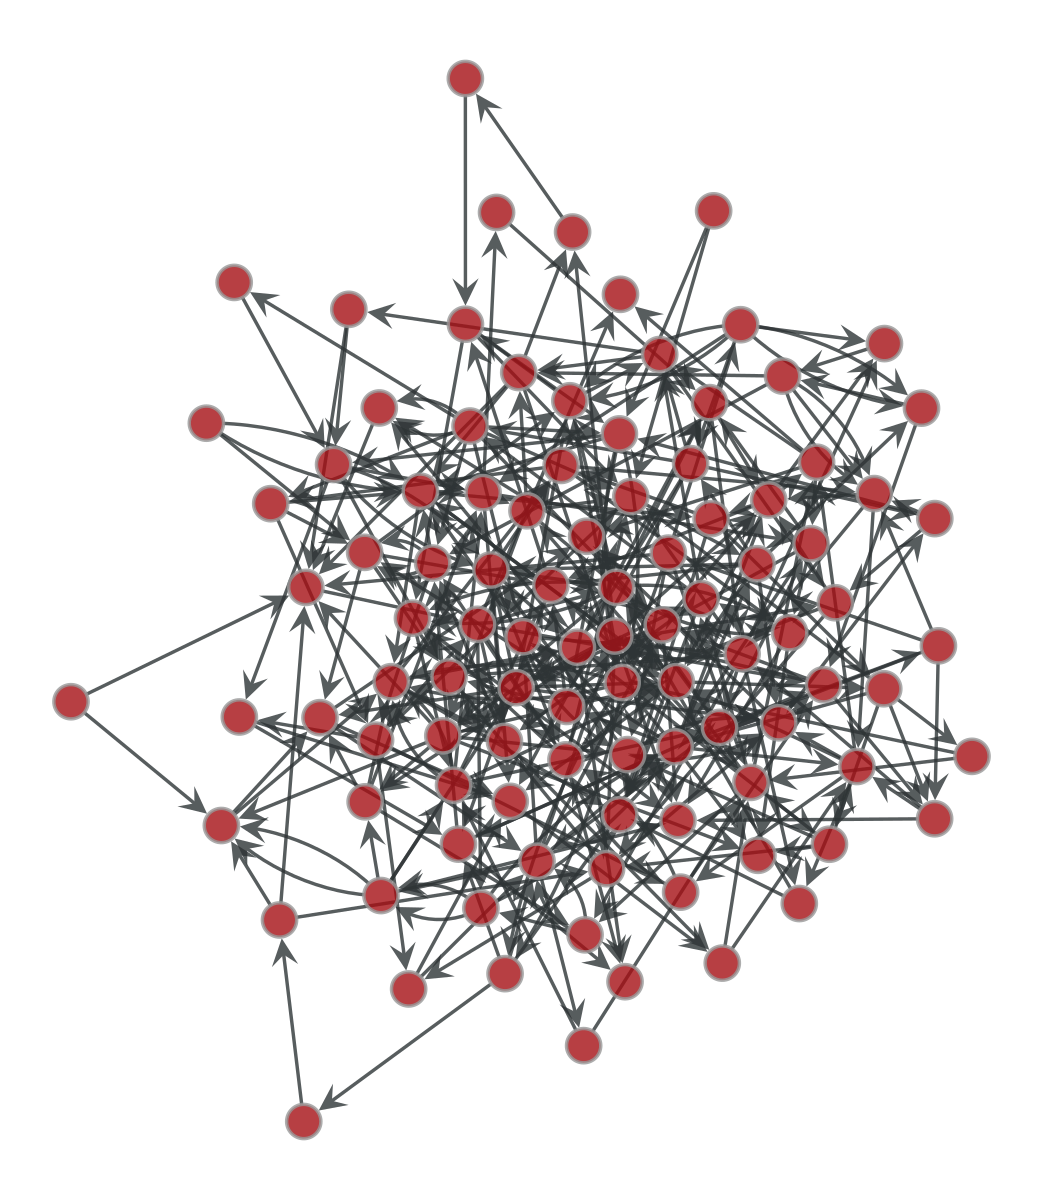

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff043051590, at 0x7ff04306a190>

In [1308]:
gt.graph_draw(g)

In [1309]:
print("\n--- With pclabel ---\n")
pclabel = m.copy()
pclabel[N//2:] = B

g.vp["pclabel"] = g.new_vertex_property("int", pclabel)
print("pclabel counts (before inference): ", np.bincount(g.vp.pclabel.a))

bs = gt.minimize_nested_blockmodel_dl(g, state_args=dict(pclabel=g.vp.pclabel), multilevel_mcmc_args=dict())

print("pclabel counts (after inference): ", np.bincount(g.vp.pclabel.a))
#print("inferred block sizes:", [*filter(None, np.bincount(bs.get_blocks().a))])
print("inferred block sizes:", [*filter(None, np.bincount(bs.get_bs()[0]))])


--- With pclabel ---

pclabel counts (before inference):  [13 15 11 11 50]
pclabel counts (after inference):  [13 15 11 11 50]
inferred block sizes: [11, 13, 15, 11, 12, 14, 11, 13]


In [1310]:
bs

<NestedBlockState object, with base <BlockState object with 100 blocks (8 nonempty), degree-corrected, for graph <Graph object, directed, with 100 vertices and 350 edges, 1 internal vertex property, at 0x7ff043051590>, at 0x7ff04307c310>, and 8 levels of sizes [(100, 8), (8, 6), (6, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5)] at 0x7ff04307c750>

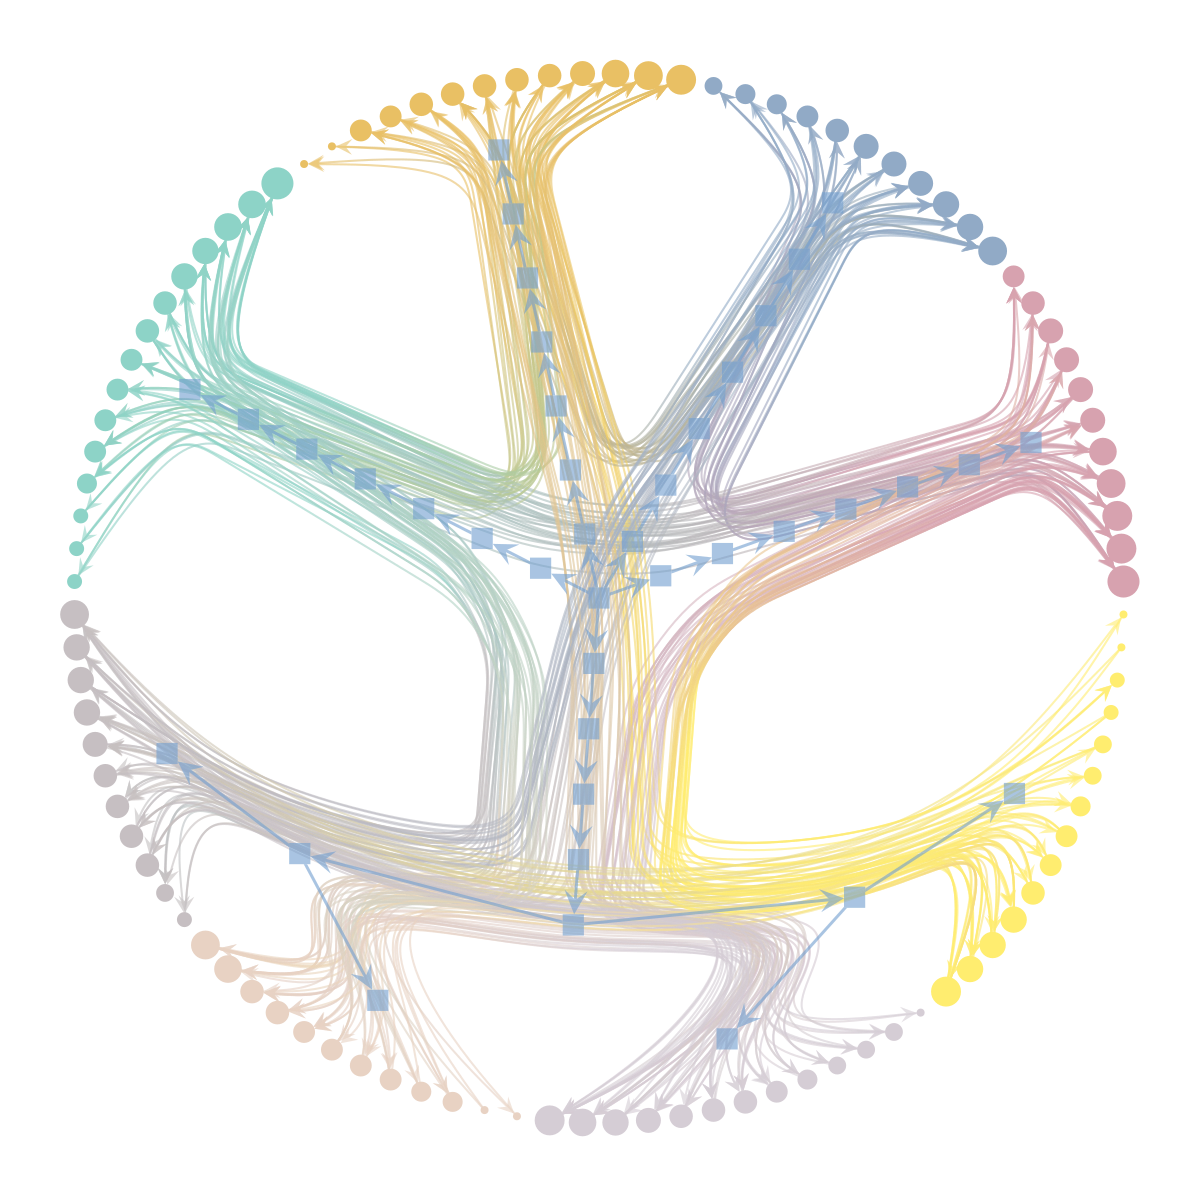

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff043051590, at 0x7ff043077f90>,
 <Graph object, directed, with 140 vertices and 139 edges, at 0x7ff043077ed0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff043077ed0, at 0x7ff043077f50>)

In [1311]:
bs.draw()

In [1175]:
np.bincount(pclabel)

array([175, 177, 148, 500])

In [1176]:
np.bincount(g.vp.pclabel.a[:])

array([175, 177, 148, 500])

In [1181]:
np.bincount(bs.get_blocks().a)

array([28, 29, 43])

In [1178]:
g.vp.pclabel.a

PropertyArray([2, 2, 1, 1, 0, 1, 1, 0, 0, 0, 2, 2, 2, 1, 1, 0, 0, 0, 1, 1,
               1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 2, 1, 0, 1,
               2, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 2,
               2, 2, 1, 0, 2, 2, 2, 2, 2, 0, 0, 1, 0, 1, 0, 2, 2, 2, 2, 1,
               0, 0, 0, 0, 1, 2, 0, 1, 0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2,
               1, 2, 2, 1, 0, 1, 2, 1, 0, 0, 0, 0, 2, 1, 0, 2, 2, 2, 0, 0,
               2, 2, 0, 2, 0, 1, 1, 2, 0, 2, 0, 1, 0, 0, 1, 1, 2, 0, 1, 0,
               2, 1, 2, 0, 1, 1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 1, 2, 1, 1, 2,
               0, 2, 0, 0, 1, 2, 1, 2, 2, 1, 0, 2, 0, 2, 0, 2, 1, 0, 0, 0,
               1, 1, 2, 1, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 0, 2, 1, 0, 1, 1,
               0, 1, 2, 1, 0, 1, 1, 0, 1, 0, 1, 2, 0, 1, 1, 2, 0, 0, 1, 0,
               0, 2, 1, 1, 2, 0, 0, 1, 2, 0, 0, 2, 0, 0, 2, 1, 0, 1, 2, 0,
               0, 1, 1, 0, 0, 0, 1, 2, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 2,
               1, 2, 0, 1